In [30]:
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [107]:
import warnings; warnings.simplefilter('ignore')

## Pima dataset


In this dataset in-total we have been given 9 features out of which, given to us are 8 independent variables and “outcome” attribute is our dependent variable. Among these 8 independent variables, 7 of them has been selected for predicting the outcome. The outcome value as 0 indicates that, person is NOT diabetic AND the outcome value as 1 indicates that, person is very well diabetic. So, the “outcome” for us is a categorical (i.e. Binary) type of variable. 

In [31]:
def get_pima_data():
    col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
    pima = pd.read_csv("data/diabetes.csv", header=None, names=col_names)
    pima.dropna()
    pima = pima.iloc[1:]
    pima.head()

    feature_cols = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']
    pima_X = pima[feature_cols].astype(float) # Features
    pima_y = pima.label.astype(float)
    pima_X.rename(columns = {'pregnant':'f1', 'insulin':'f2', 'bmi':'f3', 'age': 'f4',
                            'glucose': 'f5', 'bp': 'f6', 'pedigree': 'f7'}, inplace = True)
    pima_X = pima_X.head(550)
    pima_y = pima_y.head(550)
    pima_X = pima_X.apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())).round(2))

    return pima_X, pima_y

Also, let’s check the same aforesaid data in terms of percentages of users have Diabetes. Below data indicates that around 35% of users have diabetes and 65% don’t have diabetes.

In [32]:
pima_X, pima_y = get_pima_data()
print(pima_y.value_counts(normalize=True)*100)

0.0    64.545455
1.0    35.454545
Name: label, dtype: float64


## Breast cancer dataset

The breast cancer dataset is a classic and very easy binary classification dataset. Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. There are many features but the ten real-valued features are computed for each cell nucleus are: 
a) radius (mean of distances from center to points on the perimeter) 
b) texture (standard deviation of gray-scale values) 
c) perimeter 
d) area 
e) smoothness (local variation in radius lengths) 
f) compactness (perimeter^2 / area - 1.0) 
g) concavity (severity of concave portions of the contour) 
h) concave points (number of concave portions of the contour) 
i) symmetry 
j) fractal dimension ("coastline approximation" - 1)

among these features, seven of them have been selected and the target value is Diagnosis (M = malignant, B = benign).






In [33]:
from sklearn.datasets import load_breast_cancer

def get_cancer_data():
    cancer = load_breast_cancer()
    data = np.c_[cancer.data, cancer.target]
    columns = np.append(cancer.feature_names, ["class"])
    sizeMeasurements = pd.DataFrame(data, columns=columns)
    feature_cols = ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
                    'mean smoothness','mean compactness','mean symmetry']
    cancer_X = sizeMeasurements[feature_cols].astype(float)
    cancer_y = sizeMeasurements['class'].astype(float)
    cancer_X.rename(columns = {'mean radius':'f1', 'mean texture':'f2', 'mean perimeter':'f3', 'mean area': 'f4',
                            'mean smoothness': 'f5', 'mean compactness': 'f6', 'mean symmetry': 'f7'}, inplace = True)

    cancer_X = cancer_X.head(550)
    cancer_y = cancer_y.head(550)
    cancer_X = cancer_X.apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())).round(2))
    
    return cancer_X, cancer_y

Also, let’s check the same aforesaid data in terms of percentages of users in each class. Below data indicates that around 37% of users are in class 0 and 63% are in class 1.

In [34]:
cancer_X, cancer_y = get_cancer_data()
print(cancer_y.value_counts(normalize=True)*100)

1.0    62.545455
0.0    37.454545
Name: class, dtype: float64


## Create the graph data

Here we have a test dataset that is a comobination of the text datasets from both pima and cancer datasets mentioned above. Additionally, the features for each node of a graph is a random combination of these two datasets. For each node $i$, we first select a random number $r \in [15, 85]$ and then we randomly select $r$% of the pima dataset and $(100-r)$% of the cancer dataset as the train dataset for the node $i$.

Finally, the similarity score between nodes $i$ and $j$ is calculated based on the number of similar datapoint that they have in their training sets.

In [181]:
def get_graph():
    # load Pima dataset
    pima_X, pima_y = get_pima_data()
    
    # load cancer dataset
    cancer_X, cancer_y = get_cancer_data()
    cancer_y = cancer_y.replace(0, 2)
    cancer_y = cancer_y.replace(1, 3)
    
    # split the pima dataset to train and test datasets
    pima_X_train, pima_X_test, pima_y_train, pima_y_test = train_test_split(
        pima_X, pima_y, test_size=0.3, random_state=1) # 70% training and 30% test

    # split the cancer dataset to train and test datasets
    cancer_X_train, cancer_X_test, cancer_y_train, cancer_y_test = train_test_split(
        cancer_X, cancer_y, test_size=0.3, random_state=1) # 70% training and 30% test    
    
    
    # combine the pima and cancer test datasets
    X_test = pd.concat((pima_X_test, cancer_X_test))
    y_test = pd.concat((pima_y_test, cancer_y_test))
    

    # 
    data_len = len(pima_X_train)
    datapoints = {}
    N = 20
    node_indices = []
    for n in range(N):
        # select a random number  0.25 < r < 0.75
        r = random.random()
        while r < 0.15 or r > 0.85:
            r = random.random()
            
        # uniformly select r% of the data from pima dataset
        node_idx1 = random.sample([i for i in range(data_len)], int(data_len*r)) 
        node_pima_x = pima_X_train.iloc[node_idx1]
        node_pima_y = pima_y_train.iloc[node_idx1].values
        
        # uniformly select (1-r)% of the data from cancer dataset
        node_idx2 = random.sample([i for i in range(data_len)], int(data_len*(1-r))) 
        node_cancer_x = cancer_X_train.iloc[node_idx2]
        node_cancer_y = cancer_y_train.iloc[node_idx2].values
        
        model = LogisticRegression(multi_class='multinomial')
        if n < N//2:
            model = DecisionTreeClassifier()
        
        node_indices.append((node_idx1, node_idx2))
        datapoints[n] = {
            'features': pd.concat((node_pima_x, node_cancer_x)),
            'all_features': pd.concat((node_pima_x, node_cancer_x)),
            'labels': np.concatenate((node_pima_y, node_cancer_y)),
            'all_labels': np.concatenate((node_pima_y, node_cancer_y)),
            'sample_weights': np.ones(len(node_idx1)+len(node_idx2)),
            'model': model,
        }

        
    # calculate the similarities between nodes
    E = N * (N-1)//2
    B = np.zeros((E, N))
    weight_vec = np.zeros(E)
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            data_len = len(node_indices[i][0]) + len(node_indices[i][1])
#             w1 = len(node_indices[i][0]) - len(set(node_indices[i][0]) - set(node_indices[j][0]))
#             w2 = len(node_indices[i][1]) - len(set(node_indices[i][1]) - set(node_indices[j][1]))
            w1 = min(len(node_indices[i][0]), len(node_indices[j][0]))
            w2 = min(len(node_indices[i][1]), len(node_indices[j][1]))
            weight_vec[cnt] = (w1 + w2)/data_len
            B[cnt, i] = 1
            B[cnt, j] = -1
            cnt += 1
            
    return B, weight_vec, datapoints, X_test, y_test

            


## Algorithm


In [182]:
def algorithm(B, weight_vec, datapoints, X_test, y_test, lambda_lasso=1.0, K=100):
    test_len = len(X_test)
    
    iter_scores = []
    for k in range(K):
        
        # fit the model for each node
        for node in datapoints:
            clf = datapoints[node]['model']
            clf = clf.fit(datapoints[node]['all_features'], datapoints[node]['all_labels'], 
#                           sample_weight=datapoints[node]['sample_weights']
                         )
            datapoints[node]['model'] = clf

        # calculate the accuracy for each node
        accs = []
        for node in datapoints:
            clf = datapoints[node]['model']
            y_pred = clf.predict(X_test)
            accs.append(metrics.accuracy_score(y_test, y_pred))
        iter_scores.append(accs)

        # combine the test predictions for the adjancents node of each node
        for node in datapoints:
            datapoints[node]['all_features'] = [datapoints[node]['features']]
            datapoints[node]['all_labels'] = datapoints[node]['labels']
            datapoints[node]['sample_weights'] = np.ones(len(datapoints[node]['labels']))
            for B_neigh in np.where(B[:, node] != 0)[0]:
                w = weight_vec[B_neigh]
                for neigh in np.where(B[B_neigh, :] != 0)[0]:
                    if neigh == node:
                        continue
                    data_idx = random.sample([i for i in range(test_len)], int(test_len*w)) 
                    selected_x_test = X_test.iloc[data_idx]
                    datapoints[node]['all_features'].append(selected_x_test)
                    y_pred = datapoints[neigh]['model'].predict(selected_x_test)
                    datapoints[node]['all_labels'] = np.concatenate(
                        (datapoints[node]['all_labels'], y_pred))
                    _sample_weights = [lambda_lasso/2.0 for _ in range(len(y_pred))]
                    datapoints[node]['sample_weights'] = np.concatenate(
                        (datapoints[node]['sample_weights'], _sample_weights))

            datapoints[node]['all_features'] = pd.concat(datapoints[node]['all_features'])

    iter_scores = np.array(iter_scores)
    
    return iter_scores

In [210]:
B, weight_vec, datapoints, X_test, y_test = get_graph()

E, N = B.shape

K = 50
# federated learning accuracies
iter_scores = algorithm(B, weight_vec, datapoints, X_test, y_test, K=K)

# Individual accuracies
for node in datapoints:
    model = LogisticRegression(multi_class='multinomial')
    if node < N//2:
        model = DecisionTreeClassifier()
    datapoints[node]['model'] = model

single_iter_scores = []
for k in range(K):
    for node in datapoints:
        clf = datapoints[node]['model']
        clf = clf.fit(datapoints[node]['features'], datapoints[node]['labels'])
        datapoints[node]['model'] = clf
        
    accs = []
    for node in datapoints:
        clf = datapoints[node]['model']
        y_pred = clf.predict(X_test)
        accs.append(metrics.accuracy_score(y_test, y_pred))
    single_iter_scores.append(accs)
    
    
single_iter_scores = np.array(single_iter_scores)


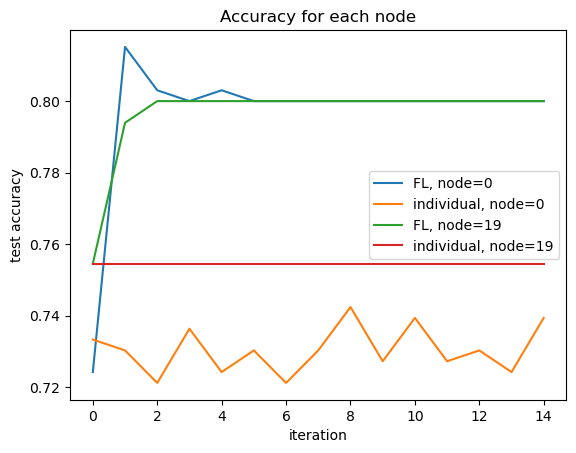

In [211]:
f = plt.figure()
x = [i for i in range(K)]
x = [i for i in range(15)]
for node in [0, 19]:
    plt.plot(x, iter_scores[:, node][:len(x)], label='FL, node=' + str(node))
    plt.plot(x, single_iter_scores[:, node][:len(x)], label='individual, node=' + str(node))

plt.title('Accuracy for each node')
plt.xlabel('iteration')
plt.ylabel('test accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
plt.close()

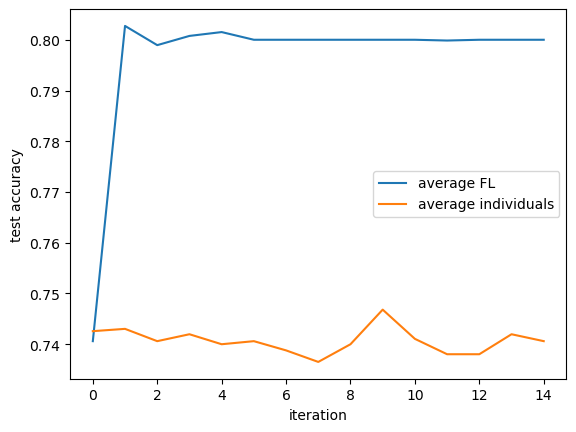

In [214]:
f = plt.figure()
x = [i for i in range(K)]
x = [i for i in range(15)]
fl_mean_acc = np.mean(iter_scores, axis=1)[:len(x)]
single_mean_acc = np.mean(single_iter_scores, axis=1)[:len(x)]
plt.plot(x, fl_mean_acc, label='average FL')
plt.plot(x, single_mean_acc, label='average individuals')

# plt.title('Mean accuracy for all the nodes')
plt.xlabel('iteration')
plt.ylabel('test accuracy')
# plt.yscale("log")
plt.legend()
plt.show()
f.savefig("./data/non-parametric/different_fl_vs_individual.pdf", bbox_inches='tight')
plt.close()

In [217]:
import json

fl_vs_individual_data = {
    'fl_mean_acc': list(fl_mean_acc),
    'individual_mean_acc': list(single_mean_acc),
}

import pandas as pd
  
data = [[i, fl_mean_acc[i], single_mean_acc[i]] for i in range(15)]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['iter', 'fl_mean', 'individual_mean'])

with open('./data/non-parametric/different_fl_vs_individual.json', 'w') as f:
    f.write(json.dumps(fl_vs_individual_data))
    
df.to_csv('./data/non-parametric/different_fl_vs_individual.csv')